In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, convolutional, normalization, Activation, Dropout, Flatten, pooling
from keras.optimizers import Adam, SGD
from keras.regularizers import l2
from keras.utils import np_utils
from keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import StratifiedShuffleSplit
import csv

np.random.seed(42) # the answer to life is a number, reproducibility

Using TensorFlow backend.


In [2]:
# I'd consider putting your datafiles in a ancenstor directory outside this file

train_images = pd.read_csv('../Hw2_data/train_data.csv', header=None).values.astype('float32')
train_labels = pd.read_csv('../Hw2_data/train_target.csv', header=None).values.astype('int32')
test_images = pd.read_csv('../Hw2_data/test_data.csv', header=None).values.astype('float32')

(16175, 2304) (16175, 1)
(3965, 2304) (3965,)


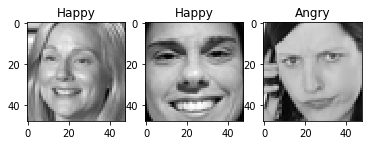

In [3]:
sample_labels = pd.read_csv('../Hw2_data/sample-submission.csv')
sample_labels.set_index('Id')
sample_labels = sample_labels['Category'].values.astype('int32')

print(train_images.shape, train_labels.shape)
print(test_images.shape, sample_labels.shape)

# Show samples from training data
images = train_images.reshape(train_images.shape[0], 48, 48)
n = 3
row = 3
labels = ['Angry', 'Happy', 'Neutral']
begin = 0 # can be random, but pick a number that reproduces results
for i in range(begin, begin + 3):
    plt.subplot(n//row, row, i%row+1)
    plt.imshow(images[i], cmap=plt.get_cmap('gray'))
    plt.title(labels[int(train_labels[i])])
plt.show()

In [4]:
def split():
    """
    Split in a stratified way to make sure the training data covers all classes
    """
    # Reshape
    X = train_images.reshape(-1,1,48,48)

    # Normalize
    X /= 255
    Y = np_utils.to_categorical(train_labels, 3)
    print('Preprocessing done')
    
    sss = StratifiedShuffleSplit(test_size=test_size, random_state=42)
    sss.split(train_images, train_labels)
    for train_index, test_index in sss.split(X, Y):
        X, X_val = X[train_index], X[test_index]
        Y, Y_val = Y[train_index], Y[test_index]
        break

    # Augment data
    
    train_aug_dir='../Hw2_data/images/training_augmented'
    if not os.path.exists(train_aug_dir):
        os.makedirs(train_aug_dir)
    test_aug_dir='../Hw2_data/images/test_augmented'
    if not os.path.exists(test_aug_dir):
        os.makedirs(test_aug_dir)

    train_datagen = ImageDataGenerator(
        zoom_range=0.2,
        horizontal_flip=True,
        data_format='channels_first',
    )
    train_datagen.fit(X)
    train_generator = train_datagen.flow(
        X,
        Y,
        seed=42,
        batch_size=batch_size,
#         save_to_dir=train_aug_dir # uncomment to see Data
    )

    validate_datagen = ImageDataGenerator(
        data_format='channels_first'
    )
    validate_datagen.fit(X_val)
    validate_generator = train_datagen.flow(
        X_val,
        Y_val,
        seed=42,
        batch_size=batch_size,
#         save_to_dir=test_aug_dir # uncomment to see Data
    )
    
    return (X, Y, X_val, Y_val, train_generator, validate_generator)

def train(model, aug_mult=2, epochs=20, batch_size=256):
    """
    Train a model
    """
    train_size = X_train.shape[0] * aug_mult
    validate_size = X_validate.shape[0] * aug_mult
    print('Training with: ')
    print('Aug training split: ', train_size)
    print('Aug test split: ', validate_size)
    
    # Adjust Learning Rate
    reduceLR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, verbose=1)
    
    # Early stopping
    earlyStopper = EarlyStopping(verbose=1, patience=15)
    
    # Begin train
    model.fit_generator(
        train_generator, 
        epochs=epochs,
        steps_per_epoch=train_size // batch_size,
        validation_data=validate_generator,
        validation_steps=validate_size // batch_size,
        verbose=1,
        callbacks=[tbCallback, checkpoint, reduceLR, earlyStopper]
    )
    
    # Save the model
    model.save('../Hw2_data/model.h5')
    
    print('Done')

In [5]:
def createModel(stacks=4, base_filter_size=32, lr=0.0003):
    """
    Deep CNN
    
    Creates a Small Neural Net made for training small images batches
    This model can reach .79 validation accuracy at .006 lr without any dropout, batch normalization, and regularization
    
    References: 
    https://shuaiw.github.io/2017/01/24/deep-learning-for-logo-recognition-part-i.html
    https://adeshpande3.github.io/adeshpande3.github.io/A-Beginner's-Guide-To-Understanding-Convolutional-Neural-Networks-Part-2/
    """
    model = Sequential()

    # one limitation is that you can't specify which stacks need dropout, batch normalization, 
    # it is something I'll work on in the future
    for i in range(0, stacks):
        model.add(convolutional.Conv2D(
            filters=base_filter_size, 
            strides=(1,1),
            kernel_size=(3,3),
            input_shape=(1,48,48),
            padding='same'
        ))
        model.add(convolutional.Conv2D(
            filters=base_filter_size,
            strides=(1,1),
            kernel_size=(3,3),
            padding='same'
        ))
        model.add(Activation('relu'))
        model.add(pooling.MaxPooling2D(
            pool_size=(2,2),
            padding='same'
        ))
        model.add(normalization.BatchNormalization())
        base_filter_size *= 2

    # Add Flatten layer
    model.add(Flatten())
    model.add(Dense(128))
#     model.add(Dropout(0.1))
    model.add(Dense(64))
    
    # FC layer with softmax
    model.add(Dense(3))
    model.add(Activation('softmax'))

    # Use RMSprop + momentum
    opt = Adam(lr)

    # Choose loss function, optimization method, and metrics to display
    model.compile(
        optimizer = opt,
        loss = 'categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

In [6]:
# Show loss and accuracy at each epoch in Tensorboard
tbCallback = TensorBoard(log_dir='./Graph', histogram_freq=0, write_graph=True, write_images=True)

# Save best model
checkpoint = ModelCheckpoint('../Hw2_data/weights.best.hdf5', monitor='val_acc', verbose=1, save_best_only=True, mode='max')

model = createModel(
    stacks=4, # 2 Conv per stack
    base_filter_size=32, # increases by 2 per stack
    lr=0.0003 # based on base model without dropout, regularizers, batch normalization
)

test_size = 0.2 # since we augment the data, this should never really be changed
batch_size = 1536 # This value seems good for GTX 980 4GB DDR3 without maxing out mem
aug_mult = 7
epochs = 1000 # any number since we can early stop based on validation loss

X_train, Y_train, X_validate, Y_validate, train_generator, validate_generator = split()

Preprocessing done


In [7]:
train(
    model, 
    aug_mult=aug_mult, 
    epochs=epochs, 
    batch_size=batch_size
)

Training with: 
Aug training split:  90580
Aug test split:  22645
Epoch 1/1000
58/58 [==============================] - 47s - loss: 1.0879 - acc: 0.5153 - val_loss: 1.0881 - val_acc: 0.4407
Epoch 2/1000
58/58 [==============================] - 42s - loss: 0.8504 - acc: 0.6134 - val_loss: 1.0848 - val_acc: 0.4405
Epoch 3/1000
58/58 [==============================] - 41s - loss: 0.7752 - acc: 0.6559 - val_loss: 1.0907 - val_acc: 0.3723
Epoch 4/1000
58/58 [==============================] - 42s - loss: 0.7100 - acc: 0.6935 - val_loss: 1.0895 - val_acc: 0.3766
Epoch 5/1000
58/58 [==============================] - 40s - loss: 0.6481 - acc: 0.7257 - val_loss: 1.0381 - val_acc: 0.5126
Epoch 6/1000
58/58 [==============================] - 43s - loss: 0.5923 - acc: 0.7540 - val_loss: 0.9806 - val_acc: 0.5270
Epoch 7/1000
58/58 [==============================] - 41s - loss: 0.5316 - acc: 0.7861 - val_loss: 0.8524 - val_acc: 0.6139
Epoch 8/1000
58/58 [==============================] - 40s - loss: 

In [8]:
# verify model was saved! You can rerun this cell for more tries
del model
model = load_model('../Hw2_data/model.h5')
train(
    model, 
    aug_mult=aug_mult, 
    epochs=0, #change if more tries needed
    batch_size=batch_size
)

Training with: 
Aug training split:  90580
Aug test split:  22645
Done


In [9]:
# load and use the best weights
model.load_weights('../Hw2_data/weights.best.hdf5')

# Make predictions
test_images = test_images.reshape(-1,1,48,48)
test_images /= 255
predictions = model.predict(test_images)

print(predictions.shape)

(3965, 3)


In [10]:
with open('../Hw2_data/predictions-deep.csv', 'w', newline="") as file:
    writer = csv.writer(file)
    writer.writerow(('Id', 'Category'))
    for i in range(0, test_images.shape[0]):
        writer.writerow((i, np.argmax(predictions[i])))